In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
dirname = config.dataset_dir + 'examples/'
config.info(dirname, len(os.listdir(dirname)))

 [INFO] : 
 |  ../datasets/examples/
 |  19


In [5]:
n = 1000 * 1
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack, r=True)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples//simple-straight-120.mid
 [INFO] : 
 |  reading file: ../datasets/examples//G3.mid
 [INFO] : 
 |  reading file: ../datasets/examples//G6.mid
 [INFO] : 
 |  reading file: ../datasets/examples//G4.mid
 [INFO] : 
 |  reading file: ../datasets/examples//G5.mid
 [INFO] : 
 |  reading file: ../datasets/examples//01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples//01 8th Cym.mid
 [INFO] : 
 |  reading file: ../datasets/examples//92_GiveItAway_TheRedHotChiliPeppers.mid
 [INFO] : 
 |  reading file: ../datasets/examples//114_LetsDance_DavidBowie1.mid
 [INFO] : 
 |  reading file: ../datasets/examples//127_SweetChildOMine_GunsAndRoses1.mid
 [INFO] : 
 |  reading file: ../datasets/examples//bossa 3.mid
 [INFO] : 
 |  reading file: ../datasets/examples//simple-shuff

In [5]:
n = 1000
min_f = 0
max_f = 3
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=3,
    d_phase=True,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 3)


In [6]:
x_train.shape

(1000, 100, 3, 1)

In [7]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(1000, 100, 3, 1), 900]

In [8]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 3)


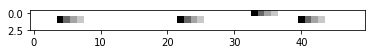

m (50, 3)


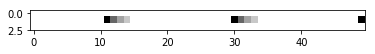

m (50, 3)


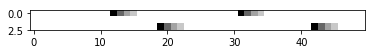

In [9]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])

In [10]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(100, 3, 1)

In [11]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [294]:
def encoder(input_size, dropout=0.05):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='valid')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='valid')(h)
    shape = K.int_shape(h)[1:]
    h = Reshape(list(shape) + [1])(h)
    h = Conv2D(128, kernel_size=(2,2), strides=1, activation='relu', padding='valid')(h)
    h = MaxPooling2D((2, 1))(h)

    h = Conv2D(64, kernel_size=(2,2), strides=2, activation='relu', padding='valid')(h)
#     print(shape, list(shape))

    # Dense layers
#     h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dropout(dropout)(h) # uncomment when using larger batches

    h = Dense(intermediate_dim, activation='relu')(h)
   
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [295]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
reshape_81 (Reshape)            (None, 100, 3)       0           input_51[0][0]                   
__________________________________________________________________________________________________
conv1d_136 (Conv1D)             (None, 50, 32)       224         reshape_81[0][0]                 
__________________________________________________________________________________________________
conv1d_137 (Conv1D)             (None, 49, 64)       4160        conv1d_136[0][0]                 
__________________________________________________________________________________________________
conv1d_138

In [296]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [297]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)
# z_output = Lambda(sampl_, output_shape=(latent_dim,))(encoder_input)

In [298]:
def list_decoders(output_size, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_size
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
#     decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim * 2, activation='relu') ]
    decoders += [ Dense(intermediate_dim * 2, activation='relu') ]
    
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]
#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolve & Pool
    
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    #     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()] # note that [].append != [] = []
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [299]:
decoders = list_decoders(input_shape)

In [300]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [301]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 1316516     input_51[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 128)          384         lambda_8[0][0]                   
__________

In [302]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=1)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_83" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_83" during training.
  # This is added back by InteractiveShellApp.init_path()


In [303]:
batch_size = 100
epochs = 100
params = {'batch_size': batch_size, 'return_y': False}

In [304]:
phase_mod = 0.01
whitening = False

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by dataset std
#         samplewise_std_normalization=False,  # divide each input by its std
# #         zca_epsilon=10,
#         zca_whitening=whitening,
#         rotation_range=0,  # randomly rotate images in 0 to 180 degrees
#         width_shift_range=0.,  # note-channel mod, but not shuffled
#         height_shift_range=phase_mod,  # start_t, phase
#         horizontal_flip=False,  # reverse
#         vertical_flip=False)

# # datagen.fit(x_train)

In [305]:
x_train.shape

(900, 100, 3, 1)

In [306]:
m = 10
useDataGenerator = False
useDataGenerator = True

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>>>>\n' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=1)
            for k,v in h.history.items(): 
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100

[Epoch 0/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 3s 274ms/step - loss: 208.0614
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 202.6278
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 15ms/step - loss: 140.8925
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 182.7597
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 137.0885
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 13ms/step - loss: 88.3270
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 89.5065
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 99.1813
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 85.0790
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 105.0026

[Epoch 1/100] >>>>>>>>>>>>

 Batch 0/

 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 63.8478
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 61.6444

[Epoch 9/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 13ms/step - loss: 63.6193
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 64.3683
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 63.3702
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 63.1322
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 64.0847
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 64.3167
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 62.9852
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.2680
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 9

 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.5839
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.6017
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 62.6132
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.4243

[Epoch 18/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.7012
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 63.6317
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.8178
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.6477
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 63.6890
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.7727
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 10ms

 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 62.2565
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 62.4045
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 61.7683
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 61.6910
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 62.4500
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 62.4676

[Epoch 27/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 63.9268
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 62.2960
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 63.4995
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 63.1313
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 

10/10 [==============================] - 0s 13ms/step - loss: 57.3809
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 60.4255
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 55.7825
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 15ms/step - loss: 55.5112
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 56.3800
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 54.7878
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 15ms/step - loss: 54.7287
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 56.9677
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 15ms/step - loss: 57.3049

[Epoch 36/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 15ms/step - loss: 56.0182
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss

 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 15ms/step - loss: 51.2235

[Epoch 44/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 48.7553
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 49.5128
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 13ms/step - loss: 48.8217
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 18ms/step - loss: 49.4573
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 13ms/step - loss: 51.8323
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 52.9704
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 53.4205
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 49.9276
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 50.5603
 Batch 9/9
Epoch 1/1
10/10 [==============================] 

 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 19ms/step - loss: 41.3386
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 17ms/step - loss: 39.2931
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 22ms/step - loss: 39.4219

[Epoch 53/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 20ms/step - loss: 41.3403
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 20ms/step - loss: 39.5626
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 18ms/step - loss: 40.2483
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 22ms/step - loss: 40.3244
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 20ms/step - loss: 39.1945
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 19ms/step - loss: 39.8440
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 23ms/step - loss: 39.7481
 Batch 7/9
Epoch 1/1
10/10 [==============================] 

10/10 [==============================] - 0s 21ms/step - loss: 35.1902
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 20ms/step - loss: 36.9288
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 31ms/step - loss: 35.9618
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 19ms/step - loss: 36.5650
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 20ms/step - loss: 34.6531
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 19ms/step - loss: 36.0174

[Epoch 62/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 19ms/step - loss: 34.8002
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 32ms/step - loss: 32.7702
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 29ms/step - loss: 34.3941
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 24ms/step - loss: 36.1338
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 20ms/step - loss

 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 36.4634
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 34.0675
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 33.1078
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 35.6572
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 35.7248
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 36.8212
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 35.8768
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 36.9242

[Epoch 71/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 31.6489
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 30.4508
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 


[Epoch 79/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 17ms/step - loss: 32.2142
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 30.0061
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 31.8466
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 31.1592
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 31.8695
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 31.5699
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 31.5770
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 34.0141
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 31.4935
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 31.7326

[Epoch 80/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==

10/10 [==============================] - 0s 16ms/step - loss: 31.2840
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 29.7722
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 32.4563

[Epoch 88/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 31.1744
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 37.3769
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 39.5664
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 32.1001
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 30.9410
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 31.5643
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 35.8238
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss:

 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s 12ms/step - loss: 30.2506
 Batch 6/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 31.8769
 Batch 7/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 33.6483
 Batch 8/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 29.5986
 Batch 9/9
Epoch 1/1
10/10 [==============================] - 0s 11ms/step - loss: 30.4866

[Epoch 97/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 31.2605
 Batch 1/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 32.4623
 Batch 2/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 32.3306
 Batch 3/9
Epoch 1/1
10/10 [==============================] - 0s 10ms/step - loss: 33.0606
 Batch 4/9
Epoch 1/1
10/10 [==============================] - 0s 9ms/step - loss: 32.4058
 Batch 5/9
Epoch 1/1
10/10 [==============================] - 0s

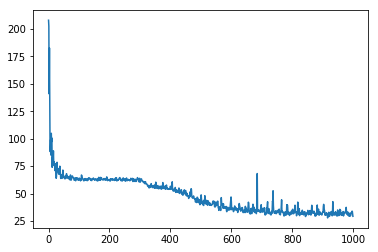

In [307]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

m (50, 3)


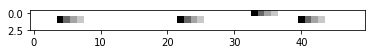

m (50, 3)


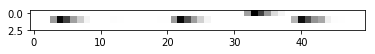

m (50, 3)


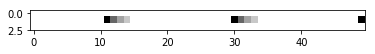

m (50, 3)


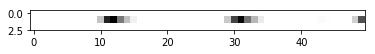

m (50, 3)


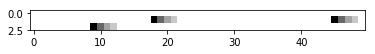

m (50, 3)


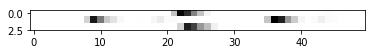

In [308]:
i = 0
j = 1
k = -1
x = vae.predict(x_train[:10])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

In [309]:
x.shape

(10, 100, 3, 1)

m (30, 3)


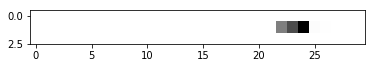

In [310]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 3)


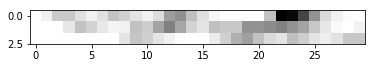

In [311]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Generator
A model to project inputs on the latent space

In [312]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [313]:
x_test.shape

(100, 100, 3, 1)

In [314]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 2)

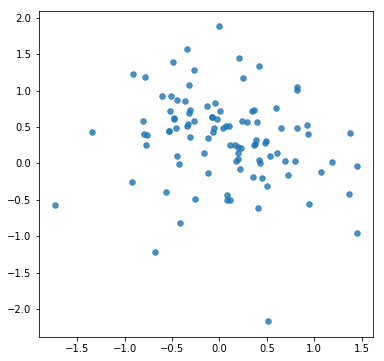

In [315]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.8, s=30) # c=y_test, 

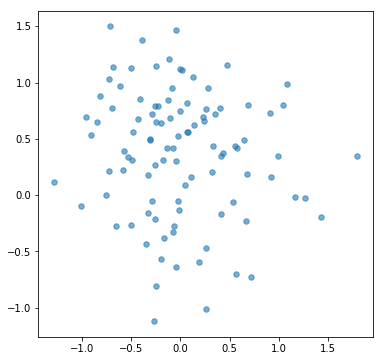

In [316]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.6, s=30) # , c=y_test
# plt.colorbar()

In [317]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [318]:
# x_decoded[0].reshape(150,3)

In [319]:
x_train.shape

(900, 100, 3, 1)

(2,) [0. 0.]


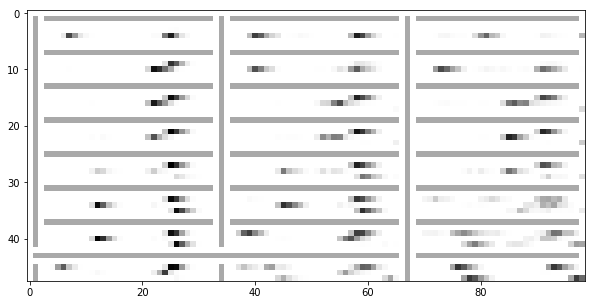

In [320]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(2,) [0. 0.]


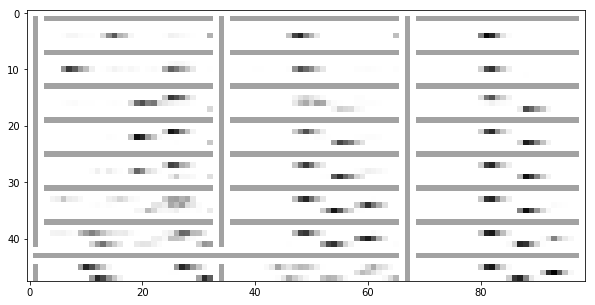

In [321]:
min_y2 = max_y
plot.latent(generator, batch_size,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)